# Background

Em primeiro lugar, vamos observar o enunciado com atenção. Se seguida está um resumo das partes importantes dele.

## Contexto
> Pretende-se que seja implementada uma solução computacional para estudo e análise de dados de grande dimensão. Nesse sentido, deverá ser contruído um modelo de análise e processamento de dados baseado em métodos e algoritmos
lecionados nas aulas

> A escolha do domínio de dados e respetico conjunto de dados a utilizar, bem [como] a formulação do próprio problema em estudo, será da responsabilidade dos autores do trabalho, [... que ...] devem ser obtidos a partr da lista de fontes especificada [...] na tabela 1

Entre as opções, nós escolhemos a competição "Predict Student Performance from Game Play" pois parecia um tema com potencial, e parece alcançável com os métodos lecionados em aula, conforme o objetivo do projeto.

## Requesitos
> [...] requisito de utilização de Apache Spark e Python é mandatório
>
> [...] vão ser utilizados serviços em ambiente cloud, da Amazon para contexto académico – AWS Academy – na qual será disponibilizada uma classe de ensino para os(as) alunos(as) da unidade curricular
>
> Os algorimos a utilizar que estarão na base da construção do [... MAPD] devem fazer parte da plataforma Apache Spark
>
> A implementação da dolução deve ser [...] composta por mais do que um notebook ou módulo Python. Compete aos autores do trabalho a estruturar [...] o código implementado.
>
> A submissão consiste num arquivo em formato zip [...] com [...] (i) relatório e (ii) notebooks e/ou módulos Python.
>
> relatório deve ser um documento sucinto e em formato pdf, com o máximo de oito [8] páginas.
>
> O prazo de submissão é 12:00 de 8 de abril de 2023 [...].


Nesta secção, vamos observar os dados que temos de forma geral, e o objetivo da competição do kaggle.

Conforme o enuncuiado do kaggle:

> The goal of this competition is to predict student performance during game-based learning in real-time.

Nós temos acesso a uma base de dados de todos os eventos de cada sessão de um utilizador, e cada sessão tem 18 questões, onde nós sabemos se a sessão acertou em cada questão. O nosso objetivo é prever, baseado nos movimentos e nas ações de uma sessão, se essa vai acertar ou errar nas questões. Vamos chamar a essas questões $q _\lambda, \lambda \in \left[ 1, 18 \right]$. O jogo parece apresentar 22 níveis, com 3 "checkpoints" de questões, um no nível 4, outro no nível 12 e o último no último nível, 22. Vamos chamar a esses níveis $n_\lambda, \lambda \in \left [1, 22\right]$. Para cada sessão $s$, temos que prever se $s$ vai acertar na questão, baseado nas ações prévias da sessão.

Para entender melhor a base de dados, nós planeamos fazer dois passos:

* Jogar o jogo.
* Interpretar os dados que nos dão.

## Jogar o jogo

O jogo encontra-se em https://pbswisconsineducation.org/jowilder/play-the-game/, e tem o título de **Jo Wilder and the Capitol Case**, produzido por *PBS Winsconsin Education*. 

O jogo simula uma investigadora mirim desvendando alguns misterios enquanto conhece a historia de sua cidade, percorrendo diversos locais na cidade é possivel explorar os edificios é elementos dentro dele, como livros, cartões é computadores.

TODO descrição melhor

## Interpretar os dados que nos dão

In [1]:
from utils.imports import *

In [2]:
from utils.start_spark import spark, reload
! start http://localhost:4040/jobs/

Ao executar `kaggle c download -p .\data\predict-student-performance-from-game-play`, e exportar o zip resultado, são exportados 4 ficheiros csv: 
* test.csv - O ficheiro do conjunto de teste 
* train.csv - O ficheiro do conjunto de treino
* train_labels.csv - O ficheiro com as respostas das sessões
* sample_submission - O ficheiro com exemplos de resposta

A página da competição descreve as colunas que estão no conjunto de treine e de teste:

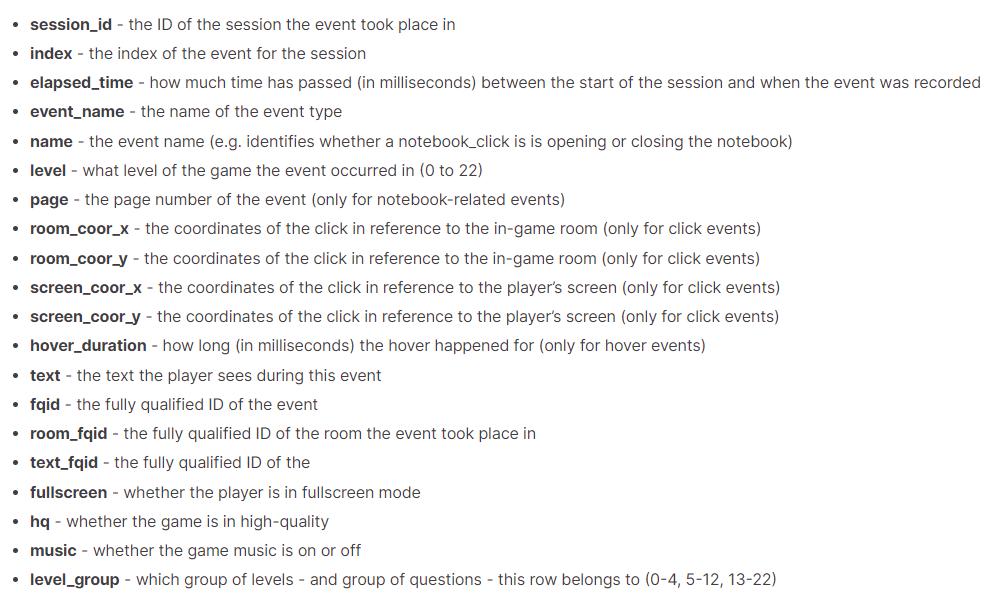

In [2]:
from files.dfs import *
readAllCsvs(spark, infer = False)
(test.df.count(), sample_submissions.df.count(), train_labels.df.count(), train.df.count())

(3728, 54, 424116, 26296946)

In [3]:
test.df.printSchema()

root
 |-- session_id: long (nullable = true)
 |-- index: integer (nullable = true)
 |-- elapsed_time: integer (nullable = true)
 |-- event_name: string (nullable = true)
 |-- name: string (nullable = true)
 |-- level: integer (nullable = true)
 |-- page: double (nullable = true)
 |-- room_coor_x: double (nullable = true)
 |-- room_coor_y: double (nullable = true)
 |-- screen_coor_x: double (nullable = true)
 |-- screen_coor_y: double (nullable = true)
 |-- hover_duration: double (nullable = true)
 |-- text: string (nullable = true)
 |-- fqid: string (nullable = true)
 |-- room_fqid: string (nullable = true)
 |-- text_fqid: string (nullable = true)
 |-- fullscreen: string (nullable = true)
 |-- hq: integer (nullable = true)
 |-- music: integer (nullable = true)
 |-- level_group: integer (nullable = true)
 |-- session_level: string (nullable = true)



In [10]:
train.df.limit(10)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20090312431273200,1,1323,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,2,831,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,3,1147,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,4,1863,person_click,basic,0,null,-412.99140522263224,-159.31468617022784,381.0,494.0,null,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,5,3423,person_click,basic,0,null,-412.99140522263224,-157.31468617022784,381.0,492.0,null,"Sure thing, Jo. Grab your notebook and come ups...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,6,5197,person_click,basic,0,null,478.48507948953636,-199.9716787422361,593.0,485.0,null,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,7,6180,person_click,basic,0,null,503.35512792584535,-168.619912992023,609.0,453.0,null,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,8,7014,person_click,basic,0,null,510.7334420194441,-157.72064191237214,615.0,442.0,null,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,9,7946,person_click,basic,0,null,512.048004999717,-153.74363056897224,616.0,438.0,null,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


Ao observar o output, podemos verificar que cada registo contém um evento de uma sessão, ordenada pelo seu `index` na sessão. Como isto não parece ser possivel trabalhar com para o objetivo do projeto, uma tentativa de transformar os dados pode ser para transformar de uma data frame de eventos para uma data frame de sessões, com as características de cada sessão.

In [11]:
(train.df.select(countDistinct("session_id")), test.df.select(countDistinct("session_id")))

(+--------------------------+
 |count(DISTINCT session_id)|
 +--------------------------+
 |                     23562|
 +--------------------------+,
 +--------------------------+
 |count(DISTINCT session_id)|
 +--------------------------+
 |                         3|
 +--------------------------+)

Podemos obervar que ficamos com 23562+3 observações. Reparamos também que o conjunto de teste apenas tem 3 observações, o que o torna um mau conjunto de teste ao aplicar a transformação planeada.

Curiosamente, reparámos já que o `elapsed_time` não parece estar totalmente conforme o `index`, mas o `index` parece estar certo porque o `text` está conforme o `index`. Para verificar se este erro se mantém, vamos selecionar os primeiros `index` de cada sessão.

In [12]:
(train.df
 .select("session_id", "index", "elapsed_time", "event_name")
 .filter("index < 5")
 .limit(20)
)

session_id,index,elapsed_time,event_name
20090312431273200,0,0,cutscene_click
20090312431273200,1,1323,person_click
20090312431273200,2,831,person_click
20090312431273200,3,1147,person_click
20090312431273200,4,1863,person_click
20090312433251036,0,0,cutscene_click
20090312433251036,1,218,person_click
20090312433251036,2,448,person_click
20090312433251036,3,702,person_click
20090312433251036,4,948,person_click


Baseado nestes resultados, não parece ser um problema. No entanto, para garantir persistência, parece uma boa ideia analisar isto mais a profundo, como por exemplo, pondo uma nova coluna que ira calcular a diferenca de tempo entre o último evento (inclusive calcular o tempo entre o último do mesmo evento).

Outra coisa que podemos reparar já é que as sessões e indexes parecem já ordenadas. Para podermos usar este facto temos que verificar que isto realmente acontece. Alternativamente, podemos garantir que este seja o facto independentemente se é o que se observa ou não, usando um `sort`. Esta alternativa parece mais fácil de implementar se necessário.

Continuando a observar a base de dados, podemos verificar que temos a coluna `event_name` parece ter um conjunto de eventos limitado.

In [13]:
train.df.groupBy('event_name').count().sort("count")

event_name,count
checkpoint,71028
observation_click,212355
map_click,517242
notebook_click,564544
notification_click,649001
map_hover,945159
object_hover,1057085
object_click,2198211
cutscene_click,2703035
person_click,6052853


### Eventos

Para analisar os eventos, vamos separar uma sessão do resto. Quando necessário iremos usar as 3 sessões do `test.df`.

In [14]:
oneSess = train.df.filter(train.df.session_id == "20090312431273200").cache()
oneSess.limit(10)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20090312431273200,1,1323,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,2,831,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,3,1147,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,4,1863,person_click,basic,0,null,-412.99140522263224,-159.31468617022784,381.0,494.0,null,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,5,3423,person_click,basic,0,null,-412.99140522263224,-157.31468617022784,381.0,492.0,null,"Sure thing, Jo. Grab your notebook and come ups...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,6,5197,person_click,basic,0,null,478.48507948953636,-199.9716787422361,593.0,485.0,null,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,7,6180,person_click,basic,0,null,503.35512792584535,-168.619912992023,609.0,453.0,null,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,8,7014,person_click,basic,0,null,510.7334420194441,-157.72064191237214,615.0,442.0,null,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,9,7946,person_click,basic,0,null,512.048004999717,-153.74363056897224,616.0,438.0,null,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


#### `checkpoint`

Em princípio, `checkpoint` deve ser a secção onde vai ser respondida as perguntas. Para isso vamos observar esses eventos na tabela.

In [15]:
test.df.filter(test.df.event_name == "checkpoint")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
20090109393214576,139,267350,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4,0
20090109393214576,684,5499227,checkpoint,basic,12,null,null,null,null,null,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12,1
20090109393214576,1313,6524025,checkpoint,basic,22,null,null,null,null,null,null,null,chap4_finale_c,tunic.capitol_2.hall,null,0,0,1,13-22,2
20090312143683264,162,323646,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4,0
20090312143683264,786,1211873,checkpoint,basic,12,null,null,null,null,null,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12,1
20090312143683264,1563,2710277,checkpoint,basic,22,null,null,null,null,null,null,null,chap4_finale_c,tunic.capitol_2.hall,null,0,0,1,13-22,2
20090312331414616,129,256276,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4,0
20090312331414616,455,779437,checkpoint,basic,12,null,null,null,null,null,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12,1
20090312331414616,1005,1587810,checkpoint,basic,22,null,null,null,null,null,null,null,chap4_finale_c,tunic.capitol_2.hall,null,0,0,1,13-22,2


Como só há 9 checkpoints, 3 por sessão, podemos confirmar que estes são as respostas às perguntas. De forma a ter mais contexto sobre estes checkpoints, vamos observar as ações prévias e posteriores ao acontecimento

In [16]:
oneSess.filter(oneSess.event_name == "checkpoint")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,164,194860,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4
20090312431273200,470,499235,checkpoint,basic,12,null,null,null,null,null,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12
20090312431273200,931,1272679,checkpoint,basic,22,null,null,null,null,null,null,null,chap4_finale_c,tunic.capitol_2.hall,null,0,0,1,13-22


In [17]:
def befAndAft(numb, bef = None, aft = None): 
    return {i for i in range(numb-(bef or 3), numb+(aft or bef or 3))}

In [18]:
(indexes := befAndAft(164)).update(befAndAft(470), befAndAft(931))
oneSess.filter(oneSess.index.isin(indexes))

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,161,161822,map_hover,basic,4,null,null,null,null,null,17.0,null,tunic.kohlcenter,tunic.kohlcenter.halloffame,null,0,0,1,0-4
20090312431273200,162,162438,map_click,undefined,4,null,-538.0933756987325,6.000000000000003,462.0,324.0,null,null,tunic.capitol_0,tunic.kohlcenter.halloffame,null,0,0,1,0-4
20090312431273200,163,164023,navigate_click,undefined,4,null,240.85698776188613,-69.35957987739589,415.0,343.0,null,null,chap1_finale,tunic.capitol_0.hall,null,0,0,1,0-4
20090312431273200,164,194860,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4
20090312431273200,467,496628,map_click,undefined,12,null,483.0783918720349,66.1253478176144,457.0,289.0,null,null,tunic.capitol_1,tunic.historicalsociety.entry,null,0,0,1,5-12
20090312431273200,468,497263,navigate_click,undefined,12,null,286.3115332164316,7.913147395331329,445.0,292.0,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12
20090312431273200,469,498894,navigate_click,undefined,12,null,291.09099384273424,32.05283158747171,554.0,288.0,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12
20090312431273200,470,499235,checkpoint,basic,12,null,null,null,null,null,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12
20090312431273200,928,1268292,map_hover,basic,22,null,null,null,null,null,366.0,null,tomap,tunic.historicalsociety.entry,null,0,0,1,13-22
20090312431273200,929,1269474,map_click,undefined,22,null,457.52300519291146,22.141338396048376,443.0,316.0,null,null,tunic.capitol_2,tunic.historicalsociety.entry,null,0,0,1,13-22


Inesperadamente, podemos observar que há eventos posteriores que faltam na tabela. Vamos aumentar o intervalo posterior ao checkpoint para analisar mais a fundo.

In [19]:
(indexes := befAndAft(164, 1, 20)).update(befAndAft(470, 1, 20), befAndAft(931, 1, 20))
oneSess.filter(oneSess["index"].isin(indexes))

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,163,164023,navigate_click,undefined,4,null,240.85698776188613,-69.35957987739589,415.0,343.0,null,null,chap1_finale,tunic.capitol_0.hall,null,0,0,1,0-4
20090312431273200,164,194860,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4
20090312431273200,175,221485,navigate_click,undefined,5,null,280.44217816384867,-19.70583676184349,653.0,321.0,null,null,boss,tunic.capitol_0.hall,null,0,0,1,5-12
20090312431273200,176,222334,person_click,basic,5,null,272.98349163285,-19.233580652926282,649.0,321.0,null,"What are you still doing here, Jolie?",boss,tunic.capitol_0.hall,tunic.capitol_0.hall.boss.talktogramps,0,0,1,5-12
20090312431273200,177,223251,person_click,basic,5,null,240.84842605041197,-228.2174499155452,628.0,459.0,null,Go find your grampa and get to work!,boss,tunic.capitol_0.hall,tunic.capitol_0.hall.boss.talktogramps,0,0,1,5-12
20090312431273200,178,223735,navigate_click,undefined,5,null,331.71468884455436,-220.62722547658038,688.0,454.0,null,null,null,tunic.capitol_0.hall,null,0,0,1,5-12
20090312431273200,179,224235,navigate_click,undefined,5,null,404.14722296892114,-226.49139561747725,716.0,454.0,null,null,null,tunic.capitol_0.hall,null,0,0,1,5-12
20090312431273200,180,224802,navigate_click,undefined,5,null,612.4026858286603,-230.57722389471024,804.0,454.0,null,null,null,tunic.capitol_0.hall,null,0,0,1,5-12
20090312431273200,181,225803,navigate_click,undefined,5,null,755.1201845707272,-213.10448097512761,824.0,441.0,null,null,toentry,tunic.capitol_0.hall,null,0,0,1,5-12
20090312431273200,182,226643,map_hover,basic,5,null,null,null,null,null,750.0,null,toentry,tunic.capitol_0.hall,null,0,0,1,5-12


Podemos observar que o intervalo usado foi suficiente para o primeiro checkpoint, mas não para os restantes. Perante este resultado, e como podemos observar o nível a mudar, suspeitamos que os indexes que faltam representam eventos do jogador a responder às questões. 

In [20]:
indexes = set()
for i in test.df.filter('event_name == "checkpoint" AND session_id == "20090312143683264"').collect():
    i = int(i["index"])
    indexes.update({j for j in range(i-1, i+5)})

test.df.filter('session_id == "20090312143683264"').filter(test.df["index"].isin(indexes))

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
20090312143683264,161,269669,navigate_click,undefined,4,null,77.8010819590221,132.97388150856182,368.0,202.0,null,null,chap1_finale,tunic.capitol_0.hall,null,0,0,1,0-4,0
20090312143683264,162,323646,checkpoint,basic,4,null,null,null,null,null,null,null,chap1_finale_c,tunic.capitol_0.hall,null,0,0,1,0-4,0
20090312143683264,785,1211382,navigate_click,undefined,12,null,273.31624570250546,59.958046194618504,477.0,273.0,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12,1
20090312143683264,786,1211873,checkpoint,basic,12,null,null,null,null,null,null,null,chap2_finale_c,tunic.capitol_1.hall,null,0,0,1,5-12,1
20090312143683264,1562,2708289,navigate_click,undefined,22,null,256.0085029134013,-116.32927684709287,425.0,374.0,null,null,chap4_finale_c,tunic.capitol_2.hall,null,0,0,1,13-22,2
20090312143683264,1563,2710277,checkpoint,basic,22,null,null,null,null,null,null,null,chap4_finale_c,tunic.capitol_2.hall,null,0,0,1,13-22,2


Parece que o padrão acontece também nas outras sessões.

#### `observation_click`

Pelo nome, suspeitamos que este seja quando o utilizador encontra uma pista.

In [21]:
oneSess.filter(oneSess.event_name == "observation_click").limit(10)

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,13,13030,observation_click,basic,0,null,486.87747070297064,-98.53828841502651,614.0,386.0,null,I love these photos of me and Teddy!,photo,tunic.historicalsociety.closet,tunic.historicalsociety.closet.photo,0,0,1,0-4
20090312431273200,37,41297,observation_click,basic,1,null,-400.3116670266166,-117.47645427492344,179.0,405.0,null,Hmm. Button's still not working.,janitor,tunic.historicalsociety.basement,tunic.historicalsociety.basement.janitor,0,0,1,0-4
20090312431273200,108,109825,observation_click,basic,3,null,14.357426035817971,-156.25368610692,444.0,485.0,null,Better check back later.,outtolunch,tunic.historicalsociety.stacks,tunic.historicalsociety.stacks.outtolunch,0,0,1,0-4
20090312431273200,112,117142,observation_click,basic,3,null,-7.493484146584201,-61.71887851734761,480.0,365.0,null,Hmm. Button's still not working.,janitor,tunic.historicalsociety.basement,tunic.historicalsociety.basement.janitor,0,0,1,0-4
20090312431273200,256,300382,observation_click,basic,6,null,75.62889527471522,-31.999999999999986,419.0,362.0,null,I bet the archivist could use this!,magnify,tunic.historicalsociety.frontdesk,tunic.historicalsociety.frontdesk.magnify,0,0,1,5-12
20090312431273200,608,920474,observation_click,basic,15,null,-49.42434014714024,-22.999999999999968,374.0,353.0,null,Yes! It's the key for Teddy's cage!,key,tunic.historicalsociety.frontdesk,tunic.historicalsociety.frontdesk.key,0,0,1,13-22
20090312431273200,725,1050634,observation_click,basic,18,null,-583.3774507526717,-775.3667941497736,215.0,577.0,null,People sure drink a lot of coffee around here.,coffee,tunic.wildlife.center,tunic.wildlife.center.coffee,0,0,1,13-22
20090312431273200,773,1091181,observation_click,basic,18,null,439.08215293389395,-423.6107861761734,547.0,349.0,null,"It's OK, girl! Look, I found you a cricket!",remove_cup,tunic.wildlife.center,tunic.wildlife.center.remove_cup,0,0,1,13-22


A primeira suspeita não parece correta. Ao observar as linhas, podemos observar que `fqid` parece tornar mais óbvio o que este evento se torna de. 

In [22]:
for i in oneSess.filter(oneSess.event_name == "observation_click").limit(15).collect():
    print(i.fqid, ":", i.text)

photo : I love these photos of me and Teddy!
janitor : Hmm. Button's still not working.
outtolunch : Better check back later.
janitor : Hmm. Button's still not working.
magnify : I bet the archivist could use this!
key : Yes! It's the key for Teddy's cage!
coffee : People sure drink a lot of coffee around here.
remove_cup : It's OK, girl! Look, I found you a cricket!


Ao tentar analisar o fqid, reparámos que nesta sessão há apenas 8 observações, uma delas repetida.

In [23]:
result = train.df.filter(train.df.event_name == "observation_click") \
    .groupby("level_group", "fqid") \
    .agg(first("text").alias("text_e"))

In [24]:
result

level_group,fqid,text_e
0-4,block_0,Gramps said to look for clues. Better look around.
0-4,block_tocollection,I should see what Grampa is up to!
0-4,block_tomap1,I should see what Gramps is up to!
0-4,block_tomap2,I should go talk to Gramps!
0-4,doorblock,I feel like I'm forgetting something.
0-4,janitor,Hmm. Button's still not working.
0-4,outtolunch,Better check back later.
0-4,photo,I love these photos of me and Teddy!
13-22,block_nelson,I should ask the librarian where to go next.
13-22,coffee,People sure drink a lot of coffee around here.


Pelo observado, podemos notar que estes eventos são os eventos onde Jo observa alguma coisa, numa espécie de monólogo. Isto pode acontecer por várias razões:
Pelo observado, podemos notar que estes eventos são os eventos onde Jo observa alguma coisa, numa espécie de monólogo. Isto pode acontecer por várias razões:

* O jogador interage com um objeto necessário para avançar (`magnify`, `remove_cup`, `key`)
* O jogador interage com um objeto necessário para avançar (`magnify`, `remove_cup`, `key`)
* O jogador tenta acessar uma área ainda não disponivel (`outtolunch`, `janitor`)
* O jogador interage com um objeto opcional, ou observa alguma coisa ( `lockeddoor`, `coffee`, `block_magnify`*, `photo`)
* O jogador tenta sair de uma sala e é bloqueado por não ter feito um objetivo necessário (`block_*`, `doorblock`, `need_glasses`)

Ao observar este facto, parece ser ideal tornar estes acontecimentos em features, possivelmente com uma contagem.

*`block_magnify` é especial, porque o objeto torna-se necessário após falar com o archeologista. Talvez seria interessante deixar este `fqid` separado dos outros.



#### `map_click`

Este evento suspeitamos que seija quando Jo vai para outro local. Se este for o caso, seira interessante usar este evento para verificar se é comum $s$ ir para o lugar errado.

In [25]:
oneSess.filter(oneSess.event_name == "map_click")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,129,135990,map_click,undefined,3,null,168.00264730466048,-142.2901345964571,263.0,417.0,null,null,tunic.kohlcenter,tunic.historicalsociety.entry,null,0,0,1,0-4
20090312431273200,162,162438,map_click,undefined,4,null,-538.0933756987325,6.000000000000003,462.0,324.0,null,null,tunic.capitol_0,tunic.kohlcenter.halloffame,null,0,0,1,0-4
20090312431273200,183,228133,map_click,undefined,5,null,456.77404867227233,167.18211481103677,559.0,198.0,null,null,tunic.historicalsociety,tunic.capitol_0.hall,null,0,0,1,5-12
20090312431273200,242,280148,map_click,close,6,null,1111.1482138602528,419.4953199489971,843.0,72.0,null,null,null,tunic.historicalsociety.entry,null,0,0,1,5-12
20090312431273200,285,324396,map_click,undefined,7,null,418.4803622590686,-200.95496783867577,420.0,453.0,null,null,tunic.humanecology,tunic.historicalsociety.entry,null,0,0,1,5-12
20090312431273200,329,357345,map_click,undefined,8,null,432.45967770454735,59.99999999999999,587.0,270.0,null,null,tunic.drycleaner,tunic.humanecology.frontdesk,null,0,0,1,5-12
20090312431273200,362,390068,map_click,undefined,9,null,-30.957167785059056,38.99999999999999,298.0,291.0,null,null,tunic.library,tunic.drycleaner.frontdesk,null,0,0,1,5-12
20090312431273200,408,436453,map_click,undefined,11,null,-385.12738602632277,46.86372199053866,451.0,294.0,null,null,tunic.capitol_1,tunic.library.frontdesk,null,0,0,1,5-12
20090312431273200,418,447415,map_click,undefined,11,null,423.9439220738474,172.90923157474182,538.0,194.0,null,null,tunic.historicalsociety,tunic.capitol_1.hall,null,0,0,1,5-12
20090312431273200,467,496628,map_click,undefined,12,null,483.0783918720349,66.1253478176144,457.0,289.0,null,null,tunic.capitol_1,tunic.historicalsociety.entry,null,0,0,1,5-12


In [26]:
(indexes := befAndAft(129)).update(befAndAft(162), befAndAft(183))
oneSess.filter(oneSess["index"].isin(indexes)) \
    .select("event_name", "fqid", "room_fqid", "level", "index")

event_name,fqid,room_fqid,level,index
navigate_click,tomap,tunic.historicalsociety.entry,3,126
map_hover,tunic.historicalsociety,tunic.historicalsociety.entry,3,127
map_hover,tunic.kohlcenter,tunic.historicalsociety.entry,3,128
map_click,tunic.kohlcenter,tunic.historicalsociety.entry,3,129
navigate_click,null,tunic.kohlcenter.halloffame,3,130
navigate_click,null,tunic.kohlcenter.halloffame,3,131
navigate_click,toentry,tunic.kohlcenter.halloffame,4,159
map_hover,toentry,tunic.kohlcenter.halloffame,4,160
map_hover,tunic.kohlcenter,tunic.kohlcenter.halloffame,4,161
map_click,tunic.capitol_0,tunic.kohlcenter.halloffame,4,162


Parece que a nossa teoria se alinha com a realidade. Esta análise revelou também que `map_hover` (e eventos semelhantes) possam ser ignorados, sendo que isso não deve revelar muita informação sem uma análise avançada.

#### `notification_click`

O nome deste evento não dá diretamente nenhuma informação sobre tal.

In [27]:
oneSess.filter(oneSess.event_name == "notification_click").select("index", "level", "text", "room_fqid")

index,level,text,room_fqid
26,0,Found it!,tunic.historicalsociety.closet
29,1,Gramps is in trouble for losing papers?,tunic.historicalsociety.closet
30,1,This can't be right!,tunic.historicalsociety.closet
31,1,Gramps is a great historian!,tunic.historicalsociety.closet
85,2,This looks like a clue!,tunic.historicalsociety.collection
86,2,I'll record this in my notebook.,tunic.historicalsociety.collection
145,3,That's it!,tunic.kohlcenter.halloffame
146,3,The slip is from 1916 but the team didn't start...,tunic.kohlcenter.halloffame
313,7,This place was around in 1916! I can start there!,tunic.humanecology.frontdesk
349,8,It's a match!,tunic.drycleaner.frontdesk


In [28]:
(indexes := befAndAft(31)).update(befAndAft(86), befAndAft(458))
oneSess.filter(oneSess["index"].isin(indexes)) \
    .select("index","event_name", "level", "text", "fqid")

index,event_name,level,text,fqid
28,navigate_click,1,null,retirement_letter
29,notification_click,1,Gramps is in trouble for losing papers?,null
30,notification_click,1,This can't be right!,null
31,notification_click,1,Gramps is a great historian!,null
32,object_click,1,null,retirement_letter
33,navigate_click,1,null,null
83,object_click,2,null,tunic
84,object_click,2,null,tunic.hub.slip
85,notification_click,2,This looks like a clue!,null
86,notification_click,2,I'll record this in my notebook.,null


Pela informação da sessão, parece que o evento acontece quando Jo encontra uma pista. Sendo que as pistas são necessárias, não tencionamos usar este evento na primeira análise.

#### `notebook_click`

Suspeitamos que este evento seja quando o utilizador clica no caderno. Como o caderno é o lugar onde as pistas e o objetivo está, se a nossa suspeita estiver correta, podemos usar clique no notebook como indicador se o utilizador precisava de rever o decorrido, ou precisava de rever o objetivo.

In [29]:
oneSess.filter(oneSess.event_name == "notebook_click")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group


Surpreendentemente, esta sessão não tem nenhum `notebook_click`.

In [30]:
test.df.filter("event_name == 'notebook_click'")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group,session_level
20090109393214576,79,133678,notebook_click,open,3,0.0,-522.5532132399363,-421.35905335608186,57.0,621.0,null,null,null,tunic.historicalsociety.collection,null,0,0,1,0-4,0
20090109393214576,80,139212,notebook_click,close,3,0.0,591.5376958509571,386.1409466439129,831.0,60.0,null,null,null,tunic.historicalsociety.collection,null,0,0,1,0-4,0
20090109393214576,118,198886,notebook_click,open,4,1.0,40.73233022176072,-292.0,51.0,622.0,null,null,null,tunic.kohlcenter.halloffame,null,0,0,1,0-4,0
20090109393214576,119,200961,notebook_click,close,4,1.0,810.7323302138033,283.0,821.0,47.0,null,null,null,tunic.kohlcenter.halloffame,null,0,0,1,0-4,0
20090109393214576,194,354784,notebook_click,open,6,1.0,-857.5892616307287,-319.16275346411726,66.0,616.0,null,null,null,tunic.historicalsociety.closet_dirty,null,0,0,1,5-12,1
20090109393214576,195,356443,notebook_click,close,6,1.0,-121.58944319812895,239.83734599606385,802.0,57.0,null,null,null,tunic.historicalsociety.closet_dirty,null,0,0,1,5-12,1
20090109393214576,214,383752,notebook_click,open,6,1.0,-55.393225071475285,-316.7457745189291,59.0,609.0,null,null,null,tunic.historicalsociety.closet_dirty,null,0,0,1,5-12,1
20090109393214576,215,388890,notebook_click,close,6,1.0,714.6067839177972,202.254225894366,829.0,90.0,null,null,null,tunic.historicalsociety.closet_dirty,null,0,0,1,5-12,1
20090109393214576,241,416019,notebook_click,open,6,1.0,-930.1325711314078,-345.0466633921455,57.0,621.0,null,null,null,tunic.historicalsociety.closet_dirty,null,0,0,1,5-12,1
20090109393214576,242,417841,notebook_click,close,6,1.0,-191.6010927570519,195.8279016174125,812.0,75.0,null,null,null,tunic.historicalsociety.closet_dirty,null,0,0,1,5-12,1


A nossa suspeita parece estar certa, de zcoro com a coluna `name`. Parece que este evento tem 3 formas: `open`, `close`, e `basic`. Enquanto que as duas primeira parecem obvias e complementam-se, o evento na forma de `basic` não é tão evidente. Suspeitamos que este evento aconteça ao virar uma página, sendo que estes eventos aparecem seguidos do `open` e antes do `close`. Estes podem mostrar rever do decorrido, mas como a inestência deles não significa o contrário, em primeira análise, estes eventos `basic` não parece tão úteis como os outros.

In [31]:
train.df.groupby("event_name").pivot("name").count()

event_name,basic,close,next,open,prev,undefined
navigate_click,null,null,null,null,null,11326433
object_click,1785270,412941,null,null,null,null
notebook_click,63416,235132,11607,235139,19250,null
observation_click,212355,null,null,null,null,null
cutscene_click,2703035,null,null,null,null,null
checkpoint,71028,null,null,null,null,null
notification_click,649001,null,null,null,null,null
person_click,6052853,null,null,null,null,null
map_hover,945159,null,null,null,null,null
map_click,46087,28623,null,null,null,442532


Podemos também notar que há eventos do tipo `prev` e `next`. Após observar melhor a base de dados, parece que ela contém a coluna `page`, o que indica a página onde o notebook está aberto. Como o evento `basic` não move esta página, suspeitamos que este evento `basic` apenas nos diz quando $s$ clica no notebook.

#### `object_click`

Suspeitamos que este evento aconteça quando $s$ clica numa pista.

In [32]:
oneSess.filter("event_name == 'object_click'")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,27,25766,object_click,close,0,null,-206.4714674868103,199.15527982561082,822.0,76.0,null,null,notebook,tunic.historicalsociety.closet,null,0,0,1,0-4
20090312431273200,32,36433,object_click,close,1,null,-113.48483160671749,241.1167323956471,836.0,62.0,null,null,retirement_letter,tunic.historicalsociety.closet,null,0,0,1,0-4
20090312431273200,50,57277,object_click,basic,1,null,856.2693578322122,69.7626061968307,839.0,291.0,null,null,report,tunic.historicalsociety.entry,null,0,0,1,0-4
20090312431273200,51,58244,object_click,close,1,null,848.1275396414932,401.94878801580046,834.0,87.0,null,null,report,tunic.historicalsociety.entry,null,0,0,1,0-4
20090312431273200,68,73927,object_click,close,2,null,439.023443951259,416.0267893465431,833.0,74.0,null,null,directory,tunic.historicalsociety.entry,null,0,0,1,0-4
20090312431273200,83,87877,object_click,basic,2,null,-15.146277343563176,12.135706766323235,403.0,321.0,null,null,tunic,tunic.historicalsociety.collection,null,0,0,1,0-4
20090312431273200,84,89383,object_click,basic,2,null,125.33553286503576,267.24537031039824,502.0,144.0,null,null,tunic.hub.slip,tunic.historicalsociety.collection,null,0,0,1,0-4
20090312431273200,88,93883,object_click,close,2,null,615.4532364708406,373.8799960261856,843.0,70.0,null,null,tunic,tunic.historicalsociety.collection,null,0,0,1,0-4
20090312431273200,144,147973,object_click,basic,3,null,530.6016479259156,-97.99999999999996,541.0,428.0,null,null,plaque.face.date,tunic.kohlcenter.halloffame,null,0,0,1,0-4
20090312431273200,147,153521,object_click,basic,3,null,523.7323250707791,-112.0,534.0,442.0,null,null,plaque,tunic.kohlcenter.halloffame,null,0,0,1,0-4


Parece que a nossa suspeita está quase verdadeira. O evento parece notar quando o utlizador interage com objetos, ou seja, quando algo aparece na cena que não seja o mapa. A maioria dessas são pistas, mas muitas delas precisam de  passos adicionas no próprio objeto para lá chegar. Por exemplo, `businesscards` tem vários eventos, um deles sendo `businesscards.card_bingo.bingo`, o que em princípio deve ser provocado pelo clique direto na pista.

Faz sentido também que muitos deste saltem `index`s, pois estes devem pertencer aos eventos de tipo `object_hover`.

Sendo que estes são necessários para o objetivo, e a análise de comportamneto deles implica uma análise profunda, não devem ser usados para esta primeira análise.

#### `cutscene_click`

Semelhantemente ao evento `notification_click`,  este pelo nome é difícl de adivinhar.

In [33]:
oneSess.filter("event_name == 'cutscene_click'")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20090312431273200,41,45062,cutscene_click,basic,1,null,93.81170338025998,-60.345449645321466,338.0,368.0,null,Let's get started. The Wisconsin Wonders exhibi...,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,42,46046,cutscene_click,basic,1,null,133.978870879124,-85.7150935705798,390.0,386.0,null,Who wants to investigate the shirt artifact?,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,43,47362,cutscene_click,basic,1,null,125.93144487538693,-83.37417718922093,390.0,385.0,null,Not Leopold here. He's been losing papers lately.,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,44,48112,cutscene_click,basic,1,null,123.70820156782429,-80.06477678318893,389.0,383.0,null,Hey!,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,45,49514,cutscene_click,basic,1,null,117.00794193032115,-76.79150900657173,385.0,381.0,null,"It's true, they do keep going missing lately.",groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,46,50144,cutscene_click,basic,1,null,116.99719336090195,-76.79055728329516,385.0,381.0,null,See?,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,47,50794,cutscene_click,basic,1,null,115.36540514340321,-81.67534496565402,384.0,384.0,null,"Besides, I already figured out the shirt.",groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,48,52413,cutscene_click,basic,1,null,113.73587727396205,-84.93196915231692,383.0,386.0,null,It's a women's basketball jersey!,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4
20090312431273200,52,58845,cutscene_click,basic,1,null,296.1122669129988,-106.10066652954552,495.0,399.0,null,That settles it.,groupconvo,tunic.historicalsociety.entry,tunic.historicalsociety.entry.groupconvo,0,0,1,0-4


De acordo com os resultados, parece que este representa os cliques dos diálogos entre as personagens. Aqui o que podemos analisar é o tempo de leitura entre mensagens, para analisar se $s$ está realmente a ler as mensagens, e o tempo que demora a ler, sendo que isso pode indicar características do utilizador, como se está com dificuldade em ler ingês. 

#### `person_click`

In [34]:
oneSess.filter("event_name == 'person_click'")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,1,1323,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,2,831,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,3,1147,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,4,1863,person_click,basic,0,null,-412.99140522263224,-159.31468617022784,381.0,494.0,null,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,5,3423,person_click,basic,0,null,-412.99140522263224,-157.31468617022784,381.0,492.0,null,"Sure thing, Jo. Grab your notebook and come ups...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,6,5197,person_click,basic,0,null,478.48507948953636,-199.9716787422361,593.0,485.0,null,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,7,6180,person_click,basic,0,null,503.35512792584535,-168.619912992023,609.0,453.0,null,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,8,7014,person_click,basic,0,null,510.7334420194441,-157.72064191237214,615.0,442.0,null,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,9,7946,person_click,basic,0,null,512.048004999717,-153.74363056897224,616.0,438.0,null,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,11,10263,person_click,basic,0,null,501.08499062304816,-164.7623661141941,605.0,445.0,null,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_5,0,0,1,0-4


Parece que o `person_click` é similar ao `cutscene_click`. Vamos ver como eles interagem.

In [35]:
oneSess.filter("event_name == 'person_click' or event_name == 'cutscene_click'")

session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
20090312431273200,0,0,cutscene_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
20090312431273200,1,1323,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,2,831,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,3,1147,person_click,basic,0,null,-413.99140522263224,-159.31468617022784,380.0,494.0,null,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,4,1863,person_click,basic,0,null,-412.99140522263224,-159.31468617022784,381.0,494.0,null,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,5,3423,person_click,basic,0,null,-412.99140522263224,-157.31468617022784,381.0,492.0,null,"Sure thing, Jo. Grab your notebook and come ups...",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0,0,1,0-4
20090312431273200,6,5197,person_click,basic,0,null,478.48507948953636,-199.9716787422361,593.0,485.0,null,"See you later, Teddy.",teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,7,6180,person_click,basic,0,null,503.35512792584535,-168.619912992023,609.0,453.0,null,I get to go to Gramps's meeting!,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,8,7014,person_click,basic,0,null,510.7334420194441,-157.72064191237214,615.0,442.0,null,Now where did I put my notebook?,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4
20090312431273200,9,7946,person_click,basic,0,null,512.048004999717,-153.74363056897224,616.0,438.0,null,\u00f0\u0178\u02dc\u00b4,teddy,tunic.historicalsociety.closet,tunic.historicalsociety.closet.teddy.intro_0_cs_0,0,0,1,0-4


Pelos resultados parece que estes são independentes.

Como parece que estes eventos são necessário também, para esta primeira análise vamos ignorar também.

### Text

Após uma pesquisa extensiva, parece que o jogo inclui 4 roteiros diferentes:
> 1. dry: no humor or snark
> 2. nohumor: no humor (includes snark)
> 3. nosnark: no snark (includes humor). No snark can also be thought of as "obedient"
> 4. normal: base script (includes snark and humor)

Mais informação no [notebook de steubk](https://www.kaggle.com/code/steubk/meetings-are-boring-the-notebook).

Nós podemos usar esta nova informação para criar uma *feature* sobre o tipo de script que $s$ está.

In [37]:
train.df.filter("fqid == 'gramps' and room_fqid == 'tunic.historicalsociety.closet'") \
    .select("session_id", "text", "text_fqid", "level_group", "event_name") \
    .limit(20)

session_id,text,text_fqid,level_group,event_name
20090312431273200,"Whatcha doing over there, Jo?",tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312431273200,Just talking to Teddy.,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312431273200,I gotta run to my meeting!,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312431273200,"Can I come, Gramps?",tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312431273200,"Sure thing, Jo. Grab your notebook and come ups...",tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312433251036,"Whatcha doing over there, Jo?",tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312433251036,Just talking to Teddy.,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312433251036,I gotta run to my meeting!,tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312433251036,"Can I come, Gramps?",tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click
20090312433251036,"Sure thing, Jo. Grab your notebook and come ups...",tunic.historicalsociety.closet.gramps.intro_0_cs_0,0-4,person_click


# *Pipeline*

Esta secção será reservada para discutir a *pipeline* adequada para o nosso objetivo. A nossa ideia seria usar um processo iterativo adaptado do lecionado em aula 

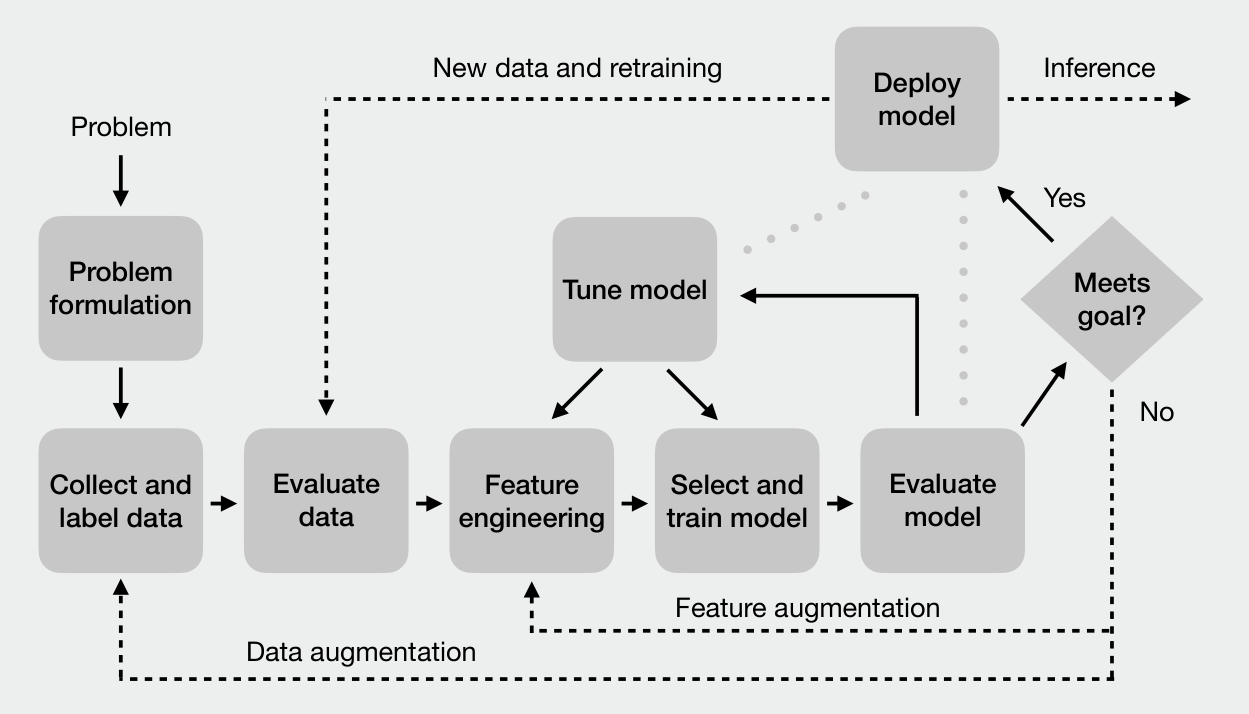
*Processo da aula*

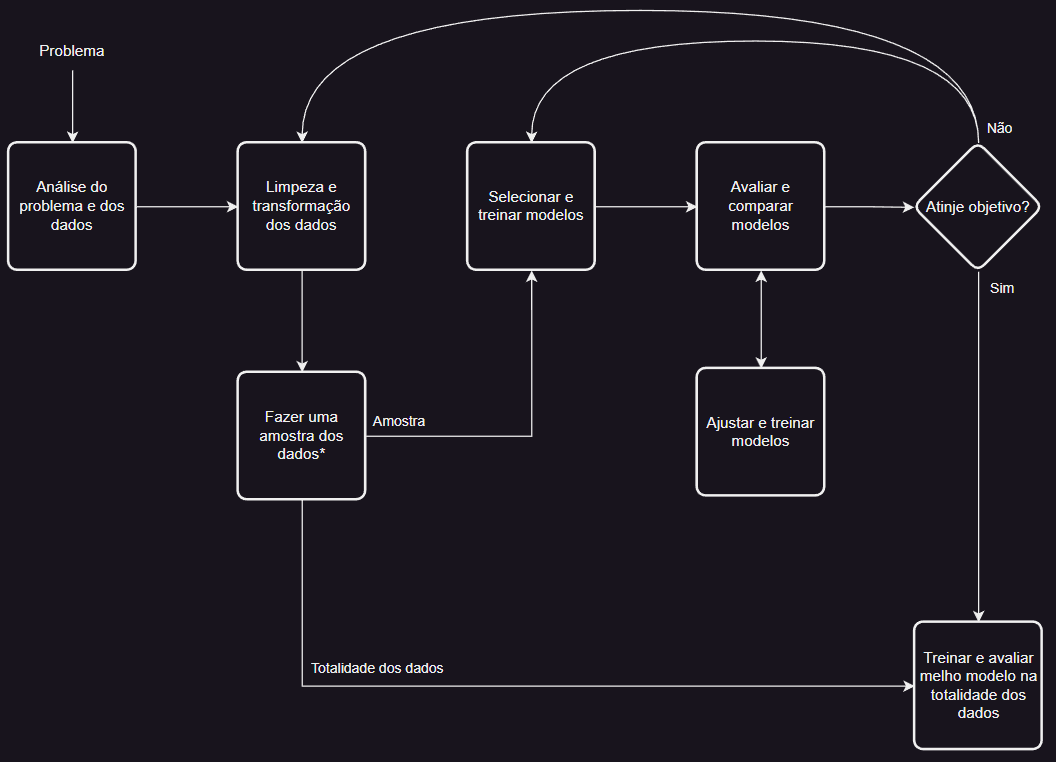
*processo adaptado*

*Por limitações computacionais, e no domínio deste projeto, planeamos em apenas usar uma amostra para avaliar e comparar modelos, e depois usar ferramentas como o AWS para treinar o modelo com a totalidade dos dados. Este processo pode ser adaptado, dependendo das propriedades base dos dados, especialmente do tamanho de tal.

Na transformação dos dados, planeamos transformar a nossa data frame para cada registo ser da sessão e um conjunto de factos sobre a sessão (incluindo as respostas da sessão).

Em termos de modelos, como este é um problema de classificação binária (respostas são ou 0 ou 1), podemos considerar modelos como regressão logística, Naive Bayes, K-Nearest Neighbours (knn), support-vector machine (SVM), entre outros. Teremos que noutro capítulo discutir quais escolher e comparar. Podemos potencialmente considerar também 

O que pode levantar questões já agora é como está formatado o objetivo. Sendo que será preciso prever 18 questões, a nossa primeira ideia será para o modelo prever um vetor (ou uma representação de tal) das 18 questões diretamente, tornando-se numa [previsão estruturada](https://en.wikipedia.org/wiki/Structured_prediction). Este formato pode dificultar a análise da previsão, sendo que o modelo estará essencialmente a prever 18 outputs, e temos que ter em atenção que as perguntas não são todas respondidas ao mesmo tempo. Alternativamente, podemos fazer um modelo que preveja cada questão separadamente; ou seja, efetivamente, 18 modelos (de caracteristicas semelhantes), treinados com a mesma base de dados, apenas com diferença na resposta que está a treinar. Isto iria diminuir a complexidade do problema, mas aumentaria o tempo e tamanho do projeto significativamente. Podemos também, em vez de 18 modelos, apenas dividir em 3 modelos, cada um para cada checkpoint; ou seja, 3 modelos para as questões da sua secção; isto parece ganhar os beneficios (e problemas) das duas opções apresentadas. Mais à frente, deve tornar-se mais obvio qual opção escolher.

Outro problema potencial imediato será de como formatar o nosso input, sendo que podemos ter uma grande quantidade de eventos por sessão, e o número de eventos por sessão são de certeza irregulares por sessão. Temos várias opções de como tornar isto num set válido para o nosso modelo ler, e a nossa primeira ideia será de agrupar um conjunto de ações possíveis no jogo (eg: número de pistas visitadas), e esperemos que seja suficiente para ter uma previsão confiável o suficiente, ou pelo menos melhor que aleatório. Temos também de ter noção da [Maldição da dimensionalidade](https://en.wikipedia.org/wiki/Curse_of_dimensionality). 

Para avaliar o modelo devemos usar métricas empiricas para o tal, dependendo de como decidirmos formatar a previsão.